## Description
This notebook processes all datasets containing German keywords (dataset_keyword_DE). It first applies a DBSCAN clustering algorithm using embeddings generated by a BERT-based model. In a second iteration, common or generic keywords are filtered out, and the clustering is performed again on the cleaned data.

The code was developed with support from ChatGPT-4.

In [1]:
import re
import ast
import pandas as pd
from nltk.corpus import stopwords
from nltk import download
from sentence_transformers import SentenceTransformer
from collections import Counter
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import umap.umap_ as umap

# Download German stopwords (only necessary once)
download('stopwords')
german_stopwords = set(stopwords.words('german'))

# Load SBERT Model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Load the dataset
inputdata_file = 'data/merged_dataset_metadata_labelled.csv'
df = pd.read_csv(inputdata_file, low_memory=False)

# Filter: only rows labeled 'T' and with iteration_index == 1 (ensures DE description and title exist)
df = df[(df['mobilitydata_labelled'] == 'T') & (df['iteration_index'].isin([1]))]

# Identify rows with non-empty dataset_keyword_DE
valid_keywords = df['dataset_keyword_DE'].notnull() & df['dataset_keyword_DE'].str.strip().ne("")

# Assign cluster = -2 for rows without valid keywords
df.loc[~valid_keywords, 'cluster'] = -2

# Tokenization function: remove stopwords and short words (≤ 2 chars)
def tokenize(text):
    tokens = re.findall(r'\b\w+\b', text.lower())
    return [token for token in tokens if token not in german_stopwords and len(token) > 2]

# Apply tokenization to valid rows only
texts = df.loc[df['cluster'] != -2, 'dataset_keyword_DE'].apply(tokenize).tolist()

print(f"{(df['cluster'] != -2).sum()} cleaned and tokenized texts with label 'T' found.")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\haabs\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


3132 cleaned and tokenized texts with label 'T' found.


In [2]:
# Convert lists of keywords into space-separated strings
documents = [" ".join(tokens) for tokens in texts]

# generate embeddings
embeddings = model.encode(documents, show_progress_bar=True)

# Perform DBSCAN clustering on the embeddings
clustering = DBSCAN(eps=0.2, min_samples=10, metric='cosine')
labels = clustering.fit_predict(embeddings)

# Reduce embeddings to 2D using UMAP for visualization
reducer = umap.UMAP(n_components=2, random_state=1)
embedding_2d = reducer.fit_transform(embeddings)

# Identify rows in the original DataFrame that are valid (cluster != -2)
valid_rows = df['cluster'] != -2

# Assign embedding coordinates and cluster labels to the corresponding rows
df.loc[valid_rows, 'x'] = embedding_2d[:, 0]
df.loc[valid_rows, 'y'] = embedding_2d[:, 1]
df.loc[valid_rows, 'cluster'] = labels
df.loc[valid_rows, 'text'] = documents

Batches:   0%|          | 0/98 [00:00<?, ?it/s]

c:\Users\haabs\anaconda3\envs\bth\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\haabs\anaconda3\envs\bth\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


C:\Users\haabs\AppData\Local\Temp\ipykernel_45496\1972152533.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap('tab20', len(unique_clusters))


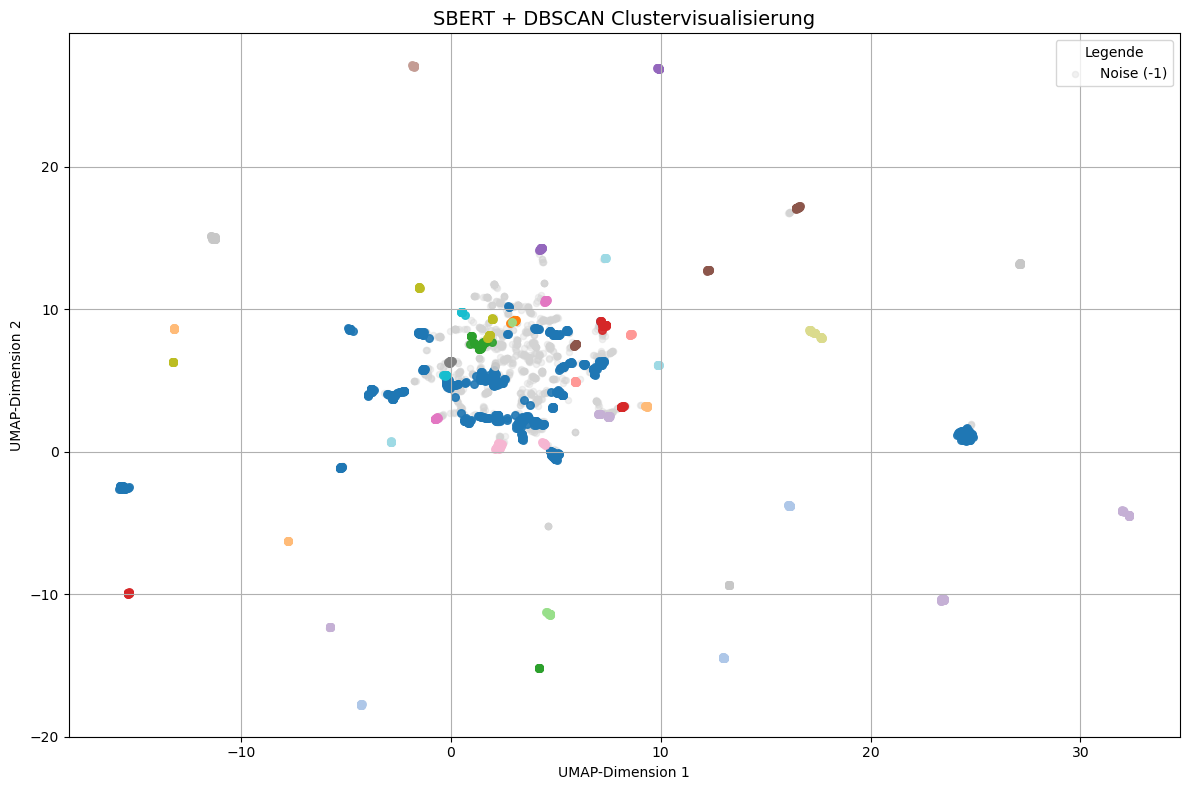

In [3]:
# Select only valid rows (cluster != -2)
valid_rows = df['cluster'] != -2
filtered_df = df[valid_rows].copy()
filtered_embedding = embedding_2d  # aligns with the filtered rows

# Extract cluster labels for filtered data
filtered_labels = filtered_df['cluster'].values

plt.figure(figsize=(12, 8))

# Get unique cluster IDs (excluding noise cluster -1)
unique_clusters = sorted(set(filtered_labels) - {-1})
color_map = plt.cm.get_cmap('tab20', len(unique_clusters))

# Plot noise points (cluster -1)
noise_mask = filtered_labels == -1
plt.scatter(
    filtered_embedding[noise_mask, 0],
    filtered_embedding[noise_mask, 1],
    c='lightgrey',
    alpha=0.3,
    s=20,
    label='Noise (-1)'
)

# Plot each valid cluster with a unique color
for idx, cluster_id in enumerate(unique_clusters):
    cluster_mask = filtered_labels == cluster_id
    plt.scatter(
        filtered_embedding[cluster_mask, 0],
        filtered_embedding[cluster_mask, 1],
        c=[color_map(idx)],
        alpha=0.9,
        s=30,
        label=None
    )

# Plot-Layout
plt.title("SBERT + DBSCAN Clustervisualisierung", fontsize=14)
plt.xlabel("UMAP-Dimension 1")
plt.ylabel("UMAP-Dimension 2")
plt.grid(True)
plt.legend(title="Legende", loc='best', fontsize=10)
plt.tight_layout()
plt.show()


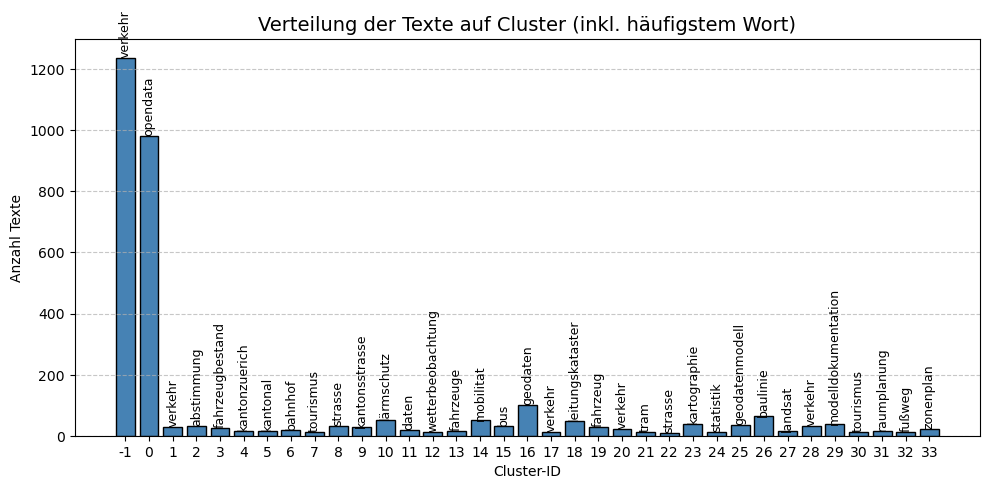

In [4]:
# Determine the most frequent word per cluster
cluster_top_words = {}

# Select only rows where cluster is not -2
valid_rows = df['cluster'] != -2

# Create a Series of token lists with matching index
token_series = pd.Series(texts, index=df[valid_rows].index)

# Assign token lists back to the original DataFrame
df.loc[valid_rows, 'tokens'] = token_series

# Compute the top word for each cluster
for cluster_id in sorted(df['cluster'].dropna().unique()):
    cluster_tokens = df[df['cluster'] == cluster_id]['tokens'].explode()
    if not cluster_tokens.empty:
        word_counts = Counter(cluster_tokens)
        most_common_word, _ = word_counts.most_common(1)[0]
        cluster_top_words[cluster_id] = most_common_word
    else:
        cluster_top_words[cluster_id] = "–"

# Filter out rows with cluster == -2
df_filtered = df[df['cluster'] != -2]

# Compute cluster size statistics
cluster_counts = df_filtered['cluster'].value_counts().sort_index()
df_stats = cluster_counts.reset_index()
df_stats.columns = ['cluster', 'Anzahl_Texte']

# Plot a bar chart of cluster sizes
plt.figure(figsize=(10, 5))
bars = plt.bar(
    df_stats['cluster'].astype(int).astype(str),  # ensure cluster IDs appear as integers
    df_stats['Anzahl_Texte'],
    color='steelblue',
    edgecolor='black'
)

plt.title("Verteilung der Texte auf Cluster (inkl. häufigstem Wort)", fontsize=14)
plt.xlabel("Cluster-ID")
plt.ylabel("Anzahl Texte")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add vertical label for the top word above each bar
for bar, cluster_id in zip(bars, df_stats['cluster'].astype(int)):
    height = bar.get_height()
    word = cluster_top_words.get(cluster_id, "–")
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 1.0,
        f'{word}',
        ha='center',
        va='bottom',
        fontsize=9,
        rotation=90
    )

plt.tight_layout()
plt.show()

In [5]:
# Define keywords to remove
keywords_to_remove = [
    'verkehr', 
    'opendata', 
    'geoportal', 
    'opendata.swiss', 
    'bgdi bundesgeodaten-infrastruktur', 
    'bgdi-bundesgeodaten-infrastruktur', 
    'geodaten',
    'geobasisdaten'
]

# Convert string representations of lists into actual Python lists
df['dataset_keyword_DE'] = df['dataset_keyword_DE'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

# Function to remove unwanted keywords from a list
def remove_keywords(keyword_list):
    if isinstance(keyword_list, list):
        return [kw for kw in keyword_list if kw.lower() not in keywords_to_remove]
    return keyword_list

# Apply the keyword removal function
df['dataset_keyword_DE'] = df['dataset_keyword_DE'].apply(remove_keywords)

# Identify empty or invalid keyword lists after filtering
empty_keyword_mask = (
    df['dataset_keyword_DE'].isna()
    | df['dataset_keyword_DE'].apply(lambda x: isinstance(x, str) and x.strip() == "")
    | df['dataset_keyword_DE'].apply(lambda x: isinstance(x, list) and len(x) == 0)
)

# Mark these rows with cluster = -2
df.loc[empty_keyword_mask, 'cluster'] = -2

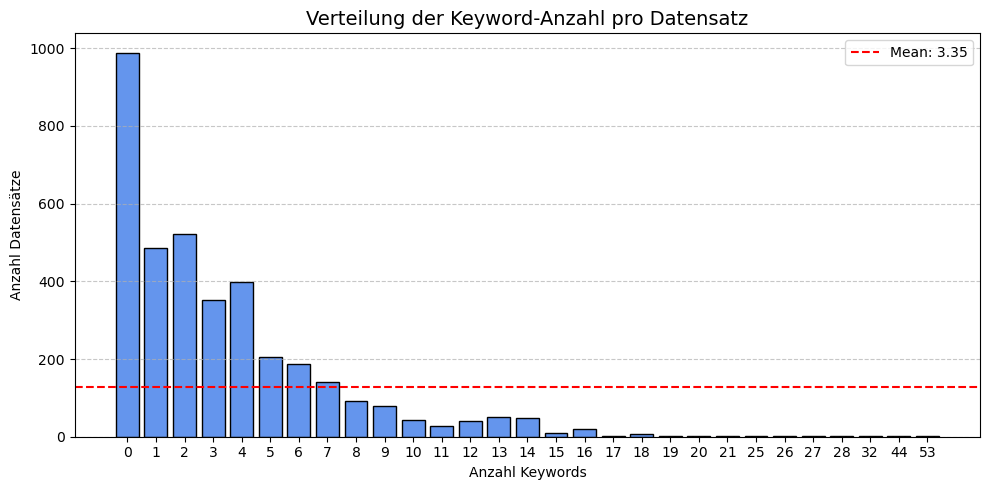

In [6]:
# Anzahl der Keywords pro Eintrag berechnen (nur gültige Listen)
df['keyword_count'] = df['dataset_keyword_DE'].apply(lambda x: len(x) if isinstance(x, list) else 0)

# Histogramm / Balkendiagramm zeichnen
plt.figure(figsize=(10, 5))
counts = df['keyword_count'].value_counts().sort_index()
bars = plt.bar(counts.index.astype(str), counts.values, color='cornflowerblue', edgecolor='black')

# Mittelwert berechnen
mean_keywords = df['keyword_count'].mean()

# Mittelwertlinie einzeichnen
plt.axhline(y=counts.mean(), color='red', linestyle='--', label=f'Mean: {mean_keywords:.2f}')

# Layout
plt.title("Verteilung der Keyword-Anzahl pro Datensatz", fontsize=14)
plt.xlabel("Anzahl Keywords")
plt.ylabel("Anzahl Datensätze")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


In [7]:
# Use only valid rows for embedding and clustering (cluster != -2)
df_valid = df[df['cluster'] != -2].copy()

# Extract token lists for embedding
cleaned_texts = df_valid['dataset_keyword_DE'].tolist()

print(f"{len(df)} cleaned and tokenized texts with label 'T' found.")

3721 cleaned and tokenized texts with label 'T' found.


In [8]:
# Convert keyword lists into space-separated strings
documents = [" ".join(tokens) for tokens in cleaned_texts]

# Generate sentence embeddings using SBERT
embeddings = model.encode(documents, show_progress_bar=True)

# Apply DBSCAN clustering to the embeddings
clustering = DBSCAN(eps=0.2, min_samples=10, metric='cosine')
labels = clustering.fit_predict(embeddings)

# Reduce dimensionality to 2D using UMAP for visualization
reducer = umap.UMAP(n_components=2, random_state=1)
embedding_2d = reducer.fit_transform(embeddings)

# Create a DataFrame for plotting
df_plot = pd.DataFrame({
    'x': embedding_2d[:, 0],
    'y': embedding_2d[:, 1],
    'cluster': labels,
    'text': documents
})

Batches:   0%|          | 0/86 [00:00<?, ?it/s]

c:\Users\haabs\anaconda3\envs\bth\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\haabs\anaconda3\envs\bth\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


C:\Users\haabs\AppData\Local\Temp\ipykernel_45496\2934963010.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap('tab20', len(unique_clusters))


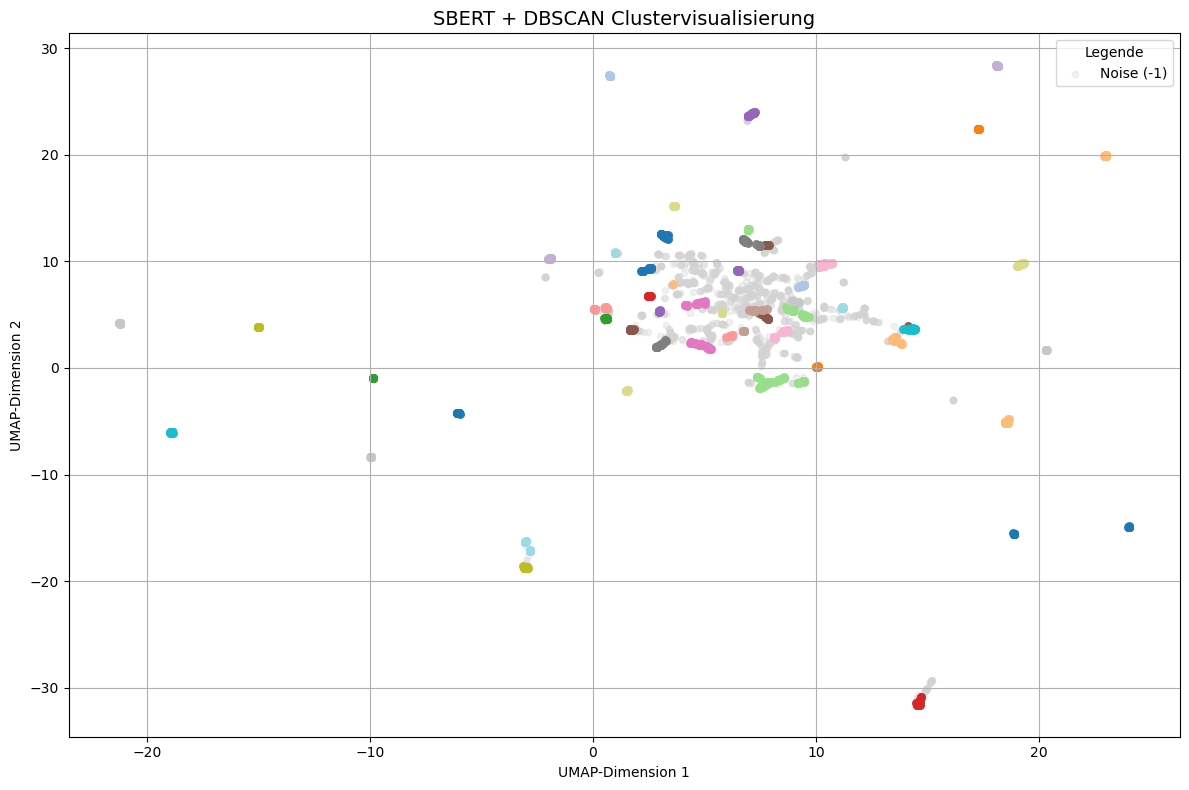

In [9]:
plt.figure(figsize=(12, 8))

# Get unique cluster labels (excluding noise cluster -1)
unique_clusters = sorted(set(labels) - {-1})
color_map = plt.cm.get_cmap('tab20', len(unique_clusters))

# Plot noise points (cluster == -1) in light grey
noise_mask = labels == -1
plt.scatter(
    embedding_2d[noise_mask, 0],
    embedding_2d[noise_mask, 1],
    c='lightgrey',
    alpha=0.3,
    s=20,
    label='Noise (-1)'
)

# Plot each valid cluster with a unique color, without legend entry
for idx, cluster_id in enumerate(unique_clusters):
    cluster_mask = labels == cluster_id
    plt.scatter(
        embedding_2d[cluster_mask, 0],
        embedding_2d[cluster_mask, 1],
        c=[color_map(idx)],
        alpha=0.9,
        s=30,
        label=None  # omit cluster ID from legend
    )

# Plot-Layout
plt.title("SBERT + DBSCAN Clustervisualisierung", fontsize=14)
plt.xlabel("UMAP-Dimension 1")
plt.ylabel("UMAP-Dimension 2")
plt.grid(True)
plt.legend(title="Legende", loc='best', fontsize=10)
plt.tight_layout()
plt.show()


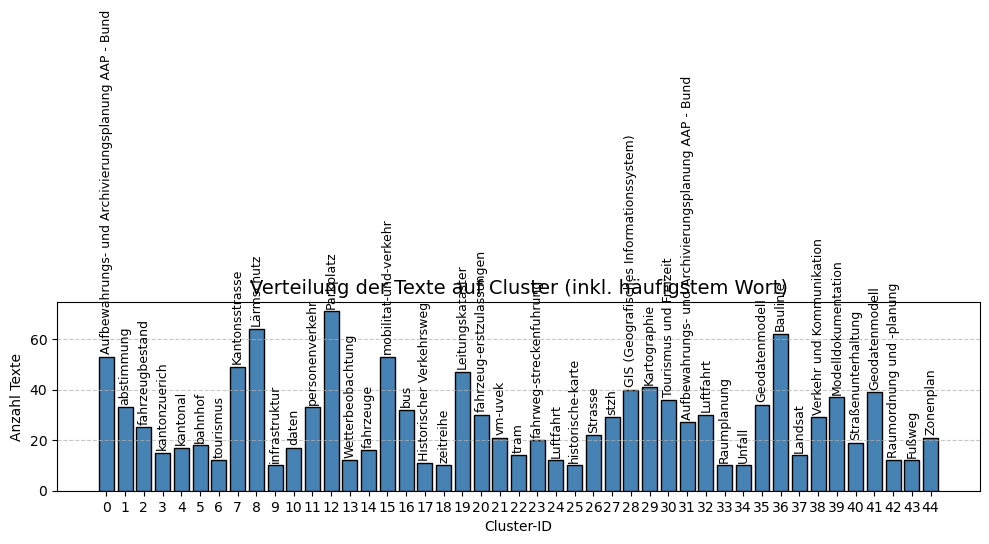

In [10]:
# Add tokenized keyword lists to the plot DataFrame
df_plot['tokens'] = cleaned_texts

# Exclude noise points (cluster == -1)
df_plot = df_plot[df_plot['cluster'] != -1]

# Determine the most frequent word per cluster
cluster_top_words = {}

for cluster_id in sorted(df_plot['cluster'].unique()):
    cluster_tokens = df_plot[df_plot['cluster'] == cluster_id]['tokens'].explode()
    if not cluster_tokens.empty:
        word_counts = Counter(cluster_tokens)
        most_common_word, _ = word_counts.most_common(1)[0]
        cluster_top_words[cluster_id] = most_common_word
    else:
        cluster_top_words[cluster_id] = "–"

# Compute cluster size statistics
cluster_counts = df_plot['cluster'].value_counts().sort_index()
df_stats = cluster_counts.reset_index()
df_stats.columns = ['cluster', 'Anzahl_Texte']

# Bar chart showing number of texts per cluster
plt.figure(figsize=(10, 5))
bars = plt.bar(df_stats['cluster'].astype(str), df_stats['Anzahl_Texte'], color='steelblue', edgecolor='black')
plt.title("Verteilung der Texte auf Cluster (inkl. häufigstem Wort)", fontsize=14)
plt.xlabel("Cluster-ID")
plt.ylabel("Anzahl Texte")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Annotate each bar with the cluster's top word (vertically rotated)
for bar in bars:
    height = bar.get_height()
    cluster_id = int(bar.get_x() + 0.5)
    word = cluster_top_words.get(cluster_id, "–")
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 1.0,
        f'{word}',
        ha='center',
        va='bottom',
        fontsize=9,
        rotation=90
    )

plt.tight_layout()
plt.show()

In [11]:
# Count occurrences of each cluster label
cluster_distribution = df['cluster'].value_counts().sort_index()

# Count of noise entries (cluster == -1)
num_noise = cluster_distribution.get(-1, 0)

# Count of entries with empty keywords (cluster == -2)
num_empty = cluster_distribution.get(-2, 0)

# Select only true clusters (cluster >= 0)
df_true_clusters = df[df['cluster'] >= 0].copy()
df_true_clusters['cluster'] = df_true_clusters['cluster'].astype(int)
true_cluster_counts = df_true_clusters['cluster'].value_counts().sort_index()

# Output statistics
print("Entries per true cluster:")
print(true_cluster_counts)
print(f"\nNumber of true clusters: {true_cluster_counts.count()}")
print(f"Number of noise entries (cluster -1): {num_noise}")
print(f"Number of entries with empty keywords (cluster -2): {num_empty}")
print(f"Total number of entries: {len(df)}")


Entries per true cluster:
cluster
0     670
1       2
2      33
3      25
4      15
5      17
6      18
7      12
8      33
9      27
10     53
11     18
12     12
13     16
14     50
15     33
16     40
17     11
18     47
19     30
20     21
21     13
22     10
23     39
24     11
25     34
26     63
27     14
28     31
29     37
30     11
31     15
32     12
33     21
Name: count, dtype: int64

Number of true clusters: 34
Number of noise entries (cluster -1): 1238
Number of entries with empty keywords (cluster -2): 989
Total number of entries: 3721


In [12]:
df.to_csv("data/01_DBSCAN_cluster.csv", index=False, encoding='utf-8')